FGSM tutorial: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

Transfer learning model from the video https://www.youtube.com/watch?v=6nQlxJvcTr0


Dataset in my own google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#####
from google.colab import files
from __future__ import print_function
#####
import torch as T
import torch.nn as nn
#######
import torch.nn.functional as F
######
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import time
import os
import argparse

def set_parameter_requires_grad(model, extracting):
  if extracting:
    for param in model.parameters():
      param.requires_grad = False

Train the model function

In [ ]:
def train_model(model, data_loaders, criterion, optimizer, num_epochs=15):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        #iterate over training and validations phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            #keeps track of total number of correct guesses
            correct = 0

            # Iterate over data.
            #dataloaders is an object that handles the loading of data
            #loads images from the directory
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                #everytime you enter a training loop- you want to zero your gradient for optimizer 
                optimizer.zero_grad()

                # forward
                # track history if only in train
                #we don't want to set gradients when we're in validation mode- only in training mode
                with T.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = T.max(outputs, 1)
                    #calculate loss
                    loss = criterion(outputs, labels)

                    # backpropogate + set optimizer only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                #keep track of running loss
                running_loss += loss.item() * inputs.size(0)
                correct += T.sum(preds == labels.data)

            epoch_loss = running_loss / len(data_loaders[phase].dataset)
            epoch_acc = correct.double() / len(data_loaders[phase].dataset)
            #.double just converts tensor to float 64

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))           

Load in the data | *Be sure that data_dir is the dataset you want to train model with

In [ ]:

data_dir = '/content/gdrive/MyDrive/CyberAI/US_UCMerced_China_images/CV2GBlur6'

### added this just to trouble shoot the use_cuda part- probably for fgsm only
use_cuda= True
###

image_transforms = {
  'train': transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'val': transforms.Compose([
      transforms.Resize(224),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])}


#opens imagefolder dataset and performing image/data transforms by iterating over train and validate folders
data_generator = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                  image_transforms[x]) for x in ['train', 'val']}

data_loader = {x: T.utils.data.DataLoader(data_generator[x], batch_size=2,
                shuffle=True, num_workers=4) for x in ['train', 'val']}

class_names = data_generator['train'].classes
device = T.device("cuda:0" if (use_cuda and T.cuda.is_available()) else "cpu")


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with T.no_grad():
        for i, (inputs, labels) in enumerate(data_loader['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = T.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} \nlabel: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.001)

params_to_update = []
for name, param in model.named_parameters():
  if param.requires_grad is True:
    params_to_update.append(param)
    print('\t', name)

List of Models: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html


Choose a model and run it

Alexnet Model

In [ ]:
model = models.alexnet(pretrained=True)
set_parameter_requires_grad(model, True)
num_features= model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 21)
model.to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

VGG11 Model

In [ ]:
model = models.vgg11_bn(pretrained=True)
set_parameter_requires_grad(model, True)
num_features= model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 21)
model.to(device)

DenseNet model

In [ ]:
model = models.densenet121(pretrained=True)
set_parameter_requires_grad(model, True)
num_features= model.classifier.in_features
model.classifier = nn.Linear(num_features, 21)
model.to(device)

Resnet18 Model (default from transfer learning tutorial)

In [ ]:
model = models.resnet18(pretrained=True)
set_parameter_requires_grad(model, True)
num_features= model.fc.in_features
model.fc = nn.Linear(num_features, 21)
model.to(device)

Train and save the model |*Be sure to change model_save_name to the appropriate name 

Afterwards, save the model to Gdrive https://medium.com/@ml_kid/how-to-save-our-model-to-google-drive-and-reuse-it-2c1028058cb2

In [ ]:
train_model(model, data_loader, criterion, optimizer)
#Naming convention- checkpointDenseNet.pth
model_save_name= 'checkpointAlexNetCV2GBlur6.pth'
path= F"/content/gdrive/MyDrive/CyberAI/{model_save_name}"
T.save(model.state_dict(), path)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.4708 Acc: 0.6296
val Loss: 1.4083 Acc: 0.6647
Epoch 1/14
----------
train Loss: 1.5055 Acc: 0.6208
val Loss: 1.4913 Acc: 0.6468
Epoch 2/14
----------
train Loss: 1.3345 Acc: 0.6541
val Loss: 1.4037 Acc: 0.6448
Epoch 3/14
----------
train Loss: 1.3823 Acc: 0.6497
val Loss: 1.2558 Acc: 0.6984
Epoch 4/14
----------
train Loss: 1.3248 Acc: 0.6522
val Loss: 1.2833 Acc: 0.7123
Epoch 5/14
----------
train Loss: 1.2730 Acc: 0.6623
val Loss: 1.5509 Acc: 0.6706
Epoch 6/14
----------
train Loss: 1.2327 Acc: 0.6911
val Loss: 1.2489 Acc: 0.6905
Epoch 7/14
----------
train Loss: 1.3215 Acc: 0.6598
val Loss: 1.3366 Acc: 0.7063
Epoch 8/14
----------
train Loss: 1.2875 Acc: 0.6598
val Loss: 1.3710 Acc: 0.6964
Epoch 9/14
----------
train Loss: 1.3872 Acc: 0.6503
val Loss: 1.6421 Acc: 0.6567
Epoch 10/14
----------
train Loss: 1.2477 Acc: 0.6711
val Loss: 1.3643 Acc: 0.6984
Epoch 11/14
----------
train Loss: 1.1283 Acc: 0.7125
val Loss: 1.1968 Acc: 0.7024
Epoch 12/14
----------
train Loss: 1

To Check Final accuracy:

In [ ]:
with T.no_grad():
    correct = 0
    total = 0
    for images, labels in data_loader['val']:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test Accuracy of the model: 79.36507936507937 %


Load the saved model

In [ ]:
model_save_name= 'checkpointResNet.pth'
state_dict = T.load(F"/content/gdrive/MyDrive/CyberAI/{model_save_name}")
print(state_dict.keys())
model.load_state_dict(state_dict)

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

<All keys matched successfully>

See the model doing some predictions with randomly vizualized pictures from the dataset

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


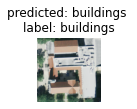

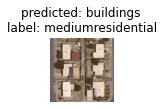

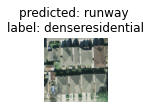

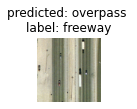

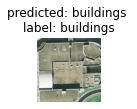

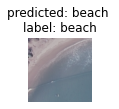

In [ ]:
visualize_model(model)